In [1]:
from utils import *
from sklearn.naive_bayes  import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk import FreqDist


import numpy as np
import nltk

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [6]:
# Recuperação dos textos - treinar o modelo somente com as classes POS e NEG
all_data = get_data_from_db()
# all_data = all_data[(all_data["labels"] == "PO") | (all_data["labels"] == "NG")]
ne_texts = all_data[(all_data["labels"] == "NE")]
ng_texts = all_data[(all_data["labels"] == "NG")]
po_texts = all_data[(all_data["labels"] == "PO")]
print('Textos carregados')

lexicon = get_LIWC_lexicon()

print("Lexico carregado")


Textos carregados
Lexico carregado


# Remoção de palavras mais e menos frenquentes

In [7]:
num_remover = NumRemover()
all_data = num_remover.fit_transform(all_data["texts"])

all_data

# all_texts = ''.join(all_data["texts"].tolist())
# cv = CountVectorizer(stop_words= stopwords.words("portuguese"))
# counts = cv.fit_transform([all_texts])
# cv.get_feature_names()

['os candidatos à presidência mais bem posicionados nas pesquisas arrecadaram  do início da campanha até o dia  de setembro  r   milhões em doações  a candidata do pt  dilma rousseff  foi a que mais captou  r    milhões  quase o dobro que a soma de seus dois principais adversários  aécio neves  do psdb  que recebeu r    milhões  e marina silva  do psb  com r    milhões ',
 'as maiores doadoras para a campanha de dilma são a construtora oas  que colaborou com r   milhões   o frigorífico jbs  com r    milhões  e a construtora andrade gutierrez  r   milhões  ',
 'os maiores colaboradores da campanha de aécio são a andrade gutierrez  com r   milhões   a jbs  r   milhões   além da oas e do banco bradesco  cada um com r   milhões  ',
 'a candidatura do psb  inicialmente com eduardo campos e depois com marina silva  recebeu as maiores doações da jbs  que deu r   milhões   da companhia sucroalcooleira copersucar  r    milhão  e da arosuco aromas e sucos  r    milhão  ',
 'em dois meses  a cand

# Stemming

In [4]:
stemmer = Stemmer()

all_texts = stemmer.fit_transform(all_data["texts"])
all_data["texts"] = all_texts

ne_texts = all_data[(all_data["labels"] == "NE")]
ng_texts = all_data[(all_data["labels"] == "NG")]
po_texts = all_data[(all_data["labels"] == "PO")]

# Aplicação do LSA

In [5]:
# cv = CountVectorizer(ngram_range = (1,2), stop_words=stopwords.words("portuguese"), vocabulary= lexicon)
cv = TfidfVectorizer(ngram_range = (1,2), stop_words=stopwords.words("portuguese"))

bag_of_words = cv.fit_transform(all_data["texts"])

svd = TruncatedSVD(n_components=5)
svd.fit(bag_of_words)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=5,
       random_state=None, tol=0.0)

# Analise de textos Neutros

<IPython.core.display.Javascript object>


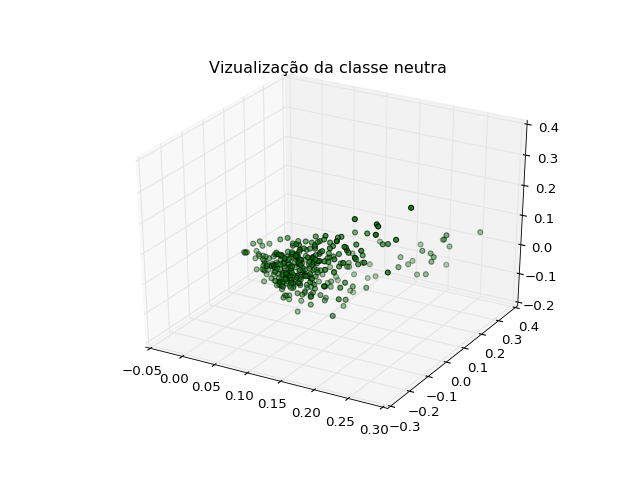

In [6]:
X_neut = svd.transform(cv.transform(ne_texts["texts"]))

# from matplotlib import pyplot as plt
# plt.plot(X_pos[:,0], X_pos[:,1], 'bo')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_neut[:,0], X_neut[:,1], X_neut[:,2], c = 'g')
ax.set_title("Vizualização da classe neutra")

In [9]:
bag_of_words.shape

(1042, 24676)

# Analise de Textos Negativos



<IPython.core.display.Javascript object>


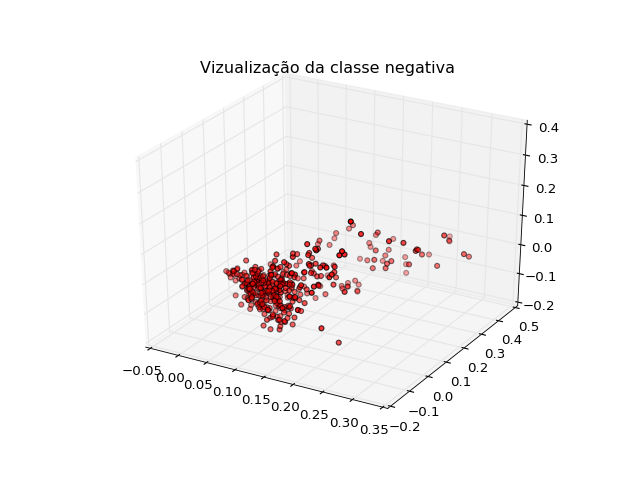

In [10]:
X_neg = svd.transform(cv.transform(ng_texts["texts"]))

%matplotlib notebook

# from matplotlib import pyplot as plt
# plt.plot(X_neg[:,0], X_neg[:,1], 'ro')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c='r')
ax.set_title("Vizualização da classe negativa")

In [22]:
X_neg.shape

(391, 3)

# Analise dos textos positivos

<IPython.core.display.Javascript object>


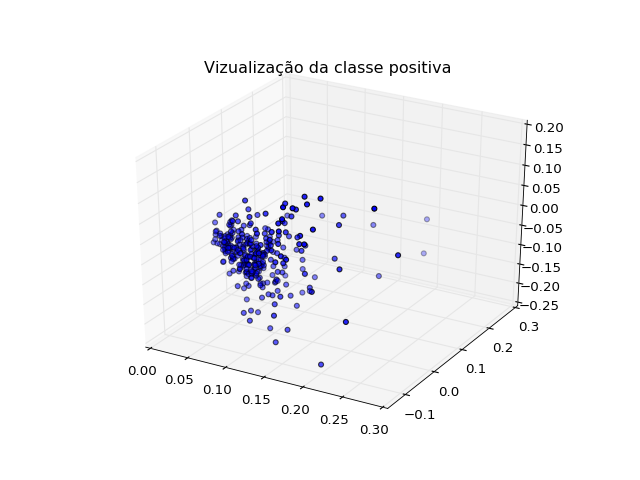

In [11]:
X_pos = svd.transform(cv.transform(po_texts["texts"]))

%matplotlib notebook

# from matplotlib import pyplot as plt
# plt.plot(X_pos[:,0], X_pos[:,1], 'bo')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'b')
ax.set_title("Vizualização da classe positiva")

# Vizualização dos dois grupos (PO e NG)

<IPython.core.display.Javascript object>


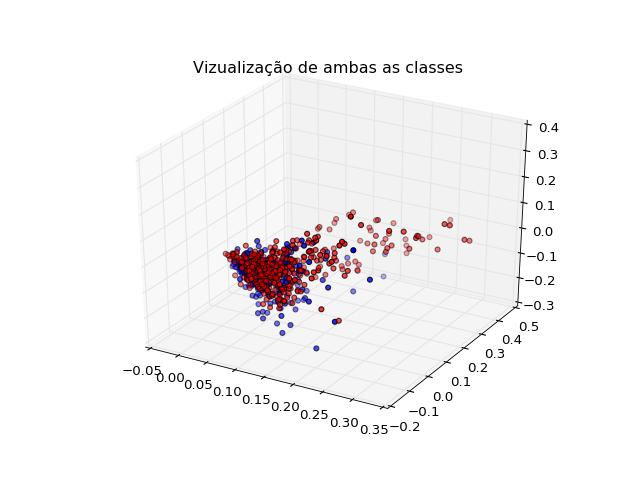

In [20]:
# from matplotlib import pyplot as plt
# plt.plot(X_neg[:,0], X_neg[:,1], 'ro', X_pos[:,0], X_pos[:,1], 'bo')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'b')
ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c = 'r')
ax.set_title("Vizualização de ambas as classes")

# Vizualização dos dois grupos (PO e NE)

<IPython.core.display.Javascript object>


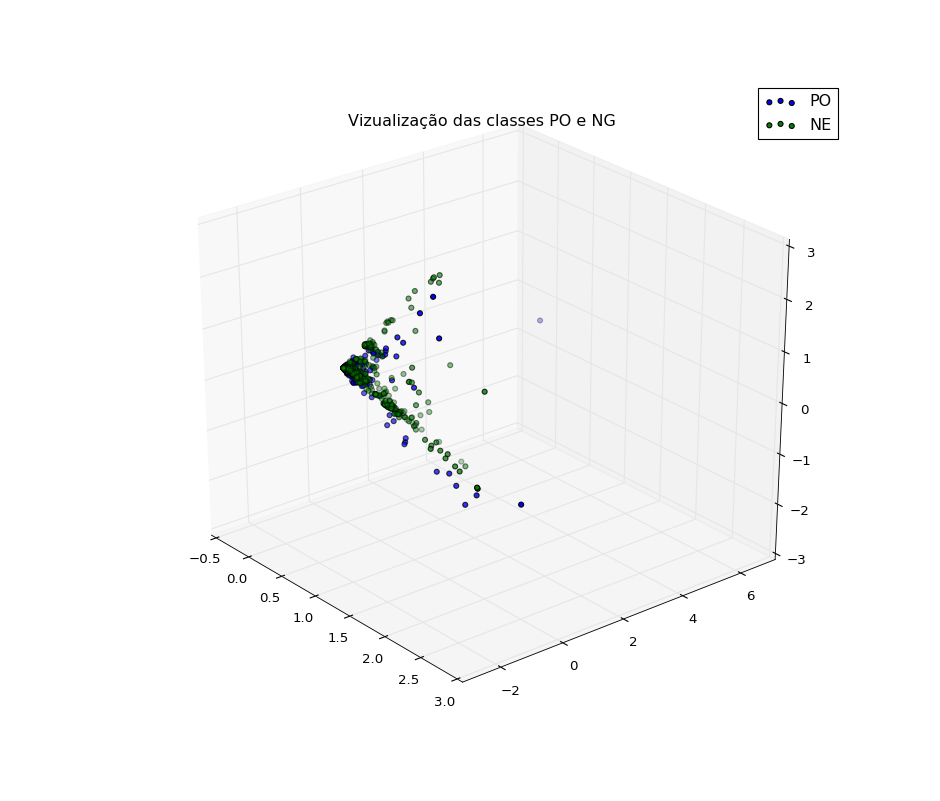

In [57]:
%matplotlib notebook
# from matplotlib import pyplot as plt
# plt.plot(X_neg[:,0], X_neg[:,1], 'ro', X_pos[:,0], X_pos[:,1], 'bo')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'b', label = "PO")
ax.scatter(X_neut[:,0], X_neut[:,1], X_neut[:,2], c = 'g', label = "NE")

ax.set_title("Vizualização das classes PO e NG")
ax.legend()

# Vizualização dos dois grupos (NG e NE)


<IPython.core.display.Javascript object>


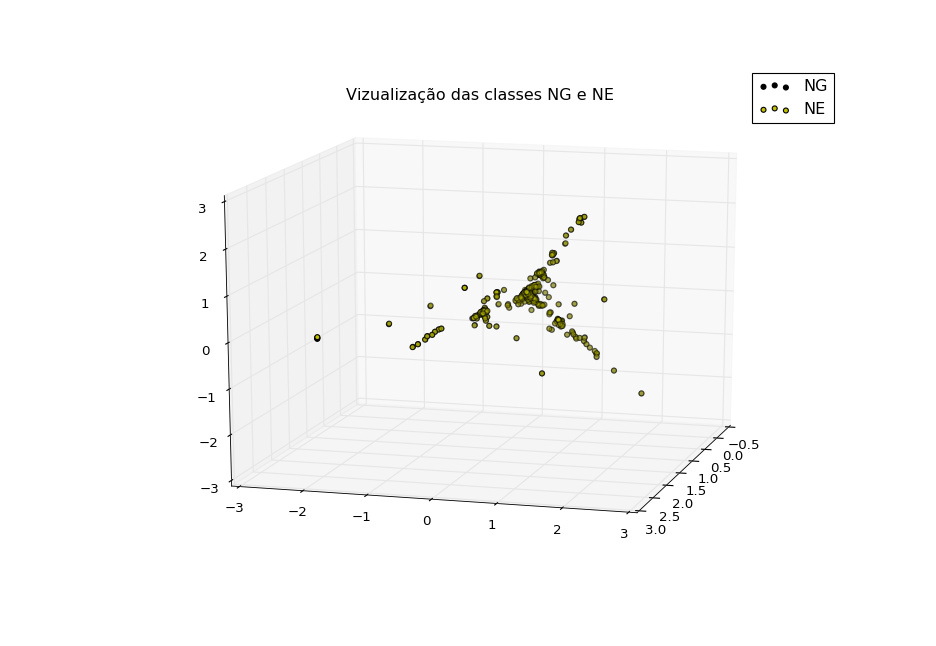

In [62]:
%matplotlib notebook
# from matplotlib import pyplot as plt
# plt.plot(X_neg[:,0], X_neg[:,1], 'ro', X_pos[:,0], X_pos[:,1], 'bo')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c = 'k', label = "NG")
ax.scatter(X_neut[:,0], X_neut[:,1], X_neut[:,2], c = 'y', label = "NE")

ax.set_title("Vizualização das classes NG e NE")
ax.legend()

# Visualização dos 3 grupos

<IPython.core.display.Javascript object>


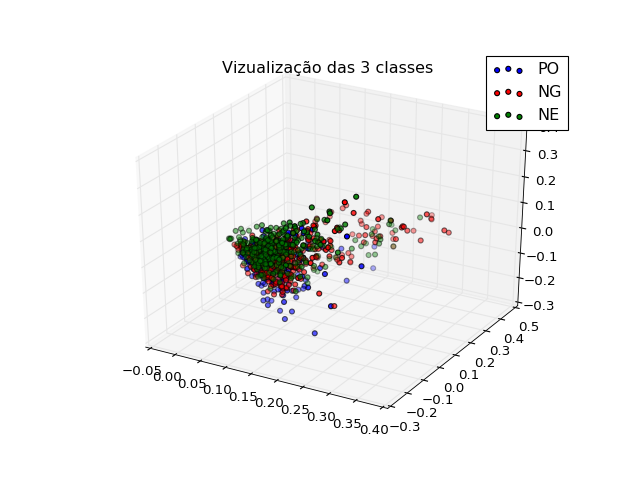

In [13]:
%matplotlib notebook
# from matplotlib import pyplot as plt
# plt.plot(X_neg[:,0], X_neg[:,1], 'ro', X_pos[:,0], X_pos[:,1], 'bo')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pos[:,0], X_pos[:,1], X_pos[:,2], c = 'b', label = "PO")
ax.scatter(X_neg[:,0], X_neg[:,1], X_neg[:,2], c = 'r', label = "NG")
ax.scatter(X_neut[:,0], X_neut[:,1], X_neut[:,2], c = 'g', label = "NE")

ax.set_title("Vizualização das 3 classes")
ax.legend()

# Classificar utilizando SVM (Utilizando somente PO e NG)

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from pandas import DataFrame
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

svm = SVC(C=500)
skfold = StratifiedKFold(n_splits=10, shuffle=True)

X_pos_data = np.append(X_pos, np.ones((X_pos.shape[0],1)), axis = 1)
X_neg_data = np.append(X_neg, np.zeros((X_neg.shape[0],1)) , axis = 1)

data = np.append(X_pos_data, X_neg_data, axis=0)

accuracy_mean = 0
for index, (train, test) in enumerate(skfold.split(data[:,0:5], data[:,5])):
    x_train = data[train,0:5]
    y_train =  data[train,5]
    
    x_test = data[test,0:5]
    y_test =  data[test,5]
    
    svm.fit(x_train, y_train)
    predictions = svm.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_mean += accuracy/10
    
    print("Fold " + str(index) + " : " + str(accuracy) )
    
print("\nAccuracia media: " + str(accuracy_mean))

Fold 0 : 0.704225352113
Fold 1 : 0.671428571429
Fold 2 : 0.614285714286
Fold 3 : 0.7
Fold 4 : 0.685714285714
Fold 5 : 0.7
Fold 6 : 0.585714285714
Fold 7 : 0.614285714286
Fold 8 : 0.628571428571
Fold 9 : 0.614285714286

Accuracia media: 0.65185110664


# Classificar utilizando SVM (Utilizando todas as classes)

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from pandas import DataFrame
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

svm = SVC(C=316)
skfold = StratifiedKFold(n_splits=10, shuffle=True)

X_pos_data = np.append(X_pos, np.ones((X_pos.shape[0],1)), axis = 1)
X_neg_data = np.append(X_neg, -np.ones((X_neg.shape[0],1)), axis = 1)
X_neu_data = np.append(X_neut, np.zeros((X_neut.shape[0],1)), axis = 1)

data = np.append(X_pos_data, X_neg_data, axis=0)
data = np.append(data, X_neu_data, axis=0)

accuracy_mean = 0
for index, (train, test) in enumerate(skfold.split(data[:,0:5], data[:,5])):
    x_train = data[train,0:5]
    y_train =  data[train,5]
    
    x_test = data[test,0:5]
    y_test =  data[test,5]
    
    svm.fit(x_train, y_train)
    predictions = svm.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_mean += accuracy/10
    
    print("Fold " + str(index) + " : " + str(accuracy) )
    
print("\nAccuracia media: " + str(accuracy_mean))

Fold 0 : 0.5
Fold 1 : 0.5
Fold 2 : 0.519230769231
Fold 3 : 0.471153846154
Fold 4 : 0.509615384615
Fold 5 : 0.548076923077
Fold 6 : 0.596153846154
Fold 7 : 0.461538461538
Fold 8 : 0.509615384615
Fold 9 : 0.490384615385

Accuracia media: 0.510576923077
